# GPT-2 lesion experiment

In the following, we assess whether lesioned versions of GPT2 can function as models of aphasia. 

To identify candidate attention heads to lesion, we replicate the syntax probing analysis of "[What Does BERT Look At?](https://arxiv.org/abs/1906.04341)" on a large selection of parsed sentences from the Penn Treebank. For subsequent lesioning we select the 30 attention heads that have accuracy > 0.6 on any dependency relation. 

First, we determine the extent to which the base GPT2 model can tell apart responses from aphasic patients and healthy controls on a picture naming task. We use data from "[A syntax–lexicon trade-off in language production](https://www.pnas.org/doi/epdf/10.1073/pnas.2120203119)", which describes the task and identifies an information-theoretic trade-off whereby patients are able to compensate for their specific linguistic deficits by making greater use of other aspects of language. We show that a classifier trained to make binary predictions about whether a text was generated by an aphasic patient v. a control from the mean surprisals of the text succeeds with a mean AUC of ~0.78. 

Next, we lesion the 30 best scoring attention heads and replicate the previous analysis. Prediction performance is significanctly degraded, with a mean AUC of ~0.6 and at or below chance performance on several folds. To establish the specificity of this particular lesion, we also select a matched number of random attention heads, and show that prediction performance is minimally changed from the base case (without any lesioning). 

In [88]:
import torch
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
from bertviz import head_view
from nltk.tokenize.treebank import TreebankWordDetokenizer
import json
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2", add_prefix_space=True)
model = GPT2LMHeadModel.from_pretrained("gpt2", output_attentions=True, return_dict=True)

## Syntax probing of GPT2

In [8]:
''' Unfortunately, the Penn Treebank is closed-source and cannot be shared here
'''
with open('./TreebankPreprocessing/output/train.json', 'r') as fi:
    data = json.load(fi)

In [ ]:
attentions = []
word_token_maps = []
tokens = []
for sentence in tqdm.tqdm(data):
    words = [word['dep_word'] for word in sentence]
    inputs = tokenizer(words, return_tensors='pt', is_split_into_words=True)
    word_to_tokens = [(inputs.word_to_tokens(idx).start, inputs.word_to_tokens(idx).end) for idx in range(len(words))]
    with torch.no_grad():
        outputs = model(**inputs)
    attention = outputs[-1]
    attentions.append(attention)
    word_token_maps.append(word_to_tokens)
    tokens.append(inputs.tokens())

In [15]:
def word_to_word_attention(sentence=0, word1=0, word2=0, layer=0, head=0):
    ''' compute attention from word2 -> word1, 
        first sum across the tokens comprising word1, 
        then average across the tokens comprising word2 (alt would be to use first token of w2)
    '''
    sent_attentions = attentions[sentence][layer][0, head, :, :]
    word1_start, word1_end = word_token_maps[sentence][word1]
    word2_start, word2_end = word_token_maps[sentence][word2]
    return sent_attentions[:, word1_start:word1_end].sum(axis=1)[word2_start:word2_end].mean()

def score_pair(sentence=0, word1=0, word2=0, layer=0, head=0):
    ''' for a given sentence, is word1 the most attended by word2? 
    '''
    word_attentions = [word_to_word_attention(sentence=sentence, word1=idx, word2=word2, layer=layer, head=head) for idx in range(word2)]
    return np.argmax(word_attentions)==word1

def score_pair_layers(sentence=0, word1=0, word2=0, layers=12, heads=12):
    score = np.zeros((layers, heads))
    for layer in range(layers):
        for head in range(heads):
            score[layer, head] = score_pair(sentence=sentence, word1=word1, word2=word2, layer=layer, head=head)
    return score

In [18]:
dependency_scores = {}
for sent_idx, sentence in enumerate(tqdm.tqdm(data)):
    for dep in sentence:
        if dep['relation'] not in ['punct', 'root']:
            if dep['head_idx'] < dep['dep_idx']:
                word1 = dep['head_idx']-1
                word2 = dep['dep_idx']-1
            else:
                word1 = dep['dep_idx']-1
                word2 = dep['head_idx']-1
            score = score_pair_layers(sentence=sent_idx, word1=word1, word2=word2)
            if dep['relation'] not in dependency_scores:
                dependency_scores[dep['relation']] = [score]
            else:
                dependency_scores[dep['relation']].append(score)

100%|█████████████████████████████████████████████████████████████████████████████████████| 39832/39832 [6:22:14<00:00,  1.74it/s]


In [ ]:
mean_scores = {}
for dep_name, deps in dependency_scores.items():
    mean_scores[dep_name] = np.mean(deps, axis=0)

In the plot below, we present, for each dependency tag in the Treebank, the proportion of sentences that each attention head correctly allocates maximum attention between the words in that dependency. 

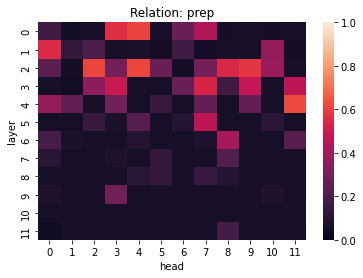

(4, 11) 0.6247618218046014


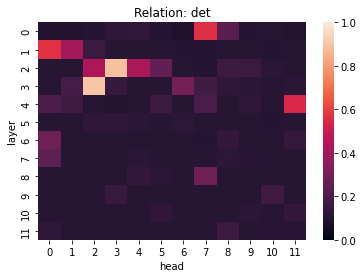

(3, 2) 0.8965781507452963


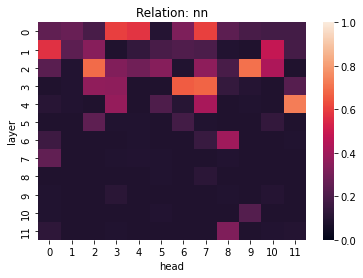

(4, 11) 0.7294965393002749


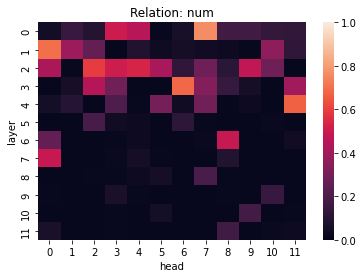

(0, 7) 0.7628063386769854


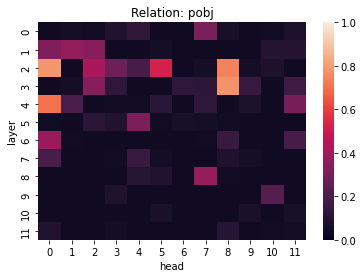

(2, 0) 0.7865301519600728


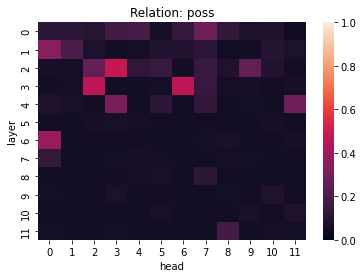

(2, 3) 0.48663133448460666


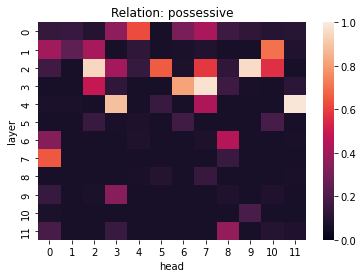

(4, 11) 0.9852013307330504


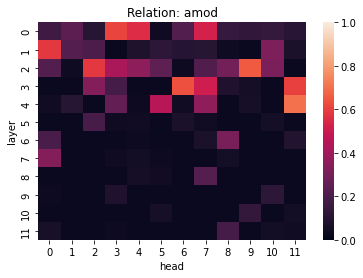

(4, 11) 0.7027707391397956


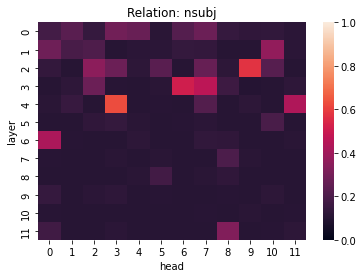

(4, 3) 0.6282637270717571


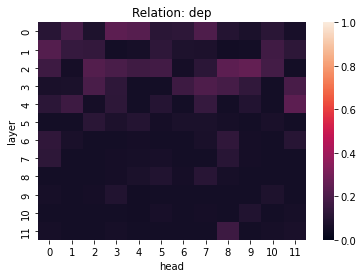

(2, 9) 0.2547661723969366


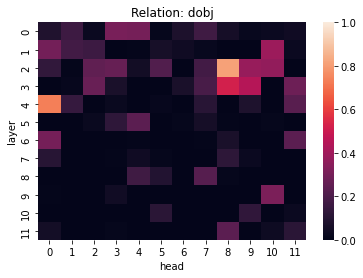

(2, 8) 0.8093252656734632


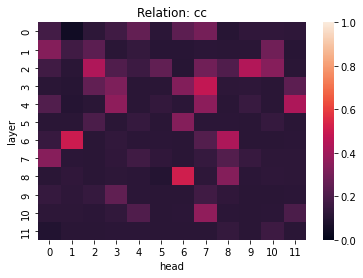

(8, 6) 0.5151881328388683


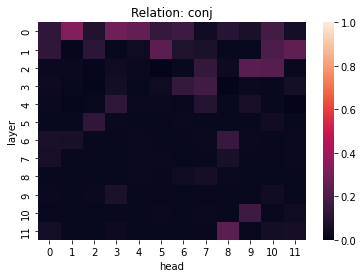

(0, 1) 0.3290296052631579


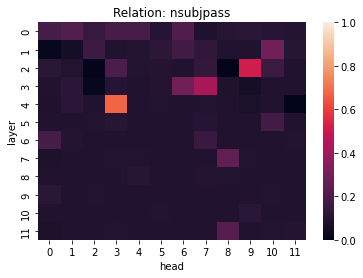

(4, 3) 0.6724266348875316


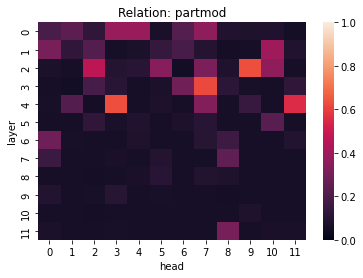

(2, 9) 0.6321779617175375


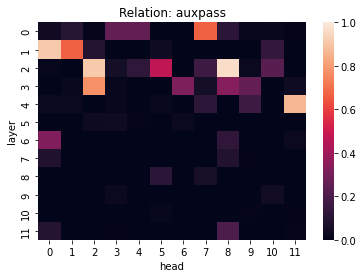

(2, 8) 0.9633919062832801


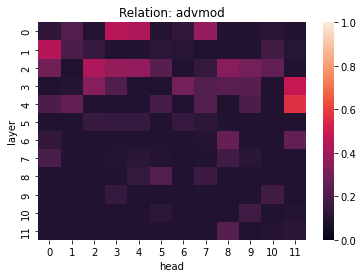

(4, 11) 0.5669016518073122


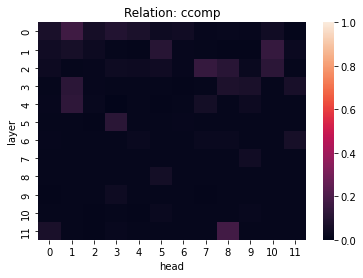

(11, 8) 0.17351302319554232


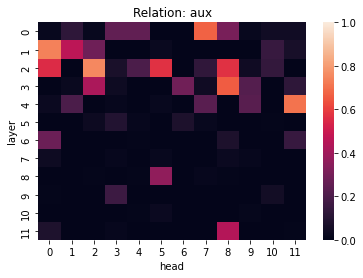

(2, 2) 0.7528262345405708


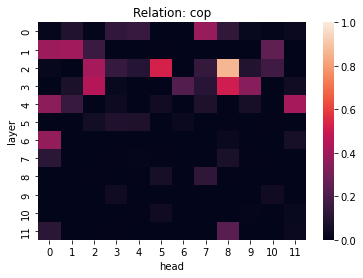

(2, 8) 0.8611449451887941


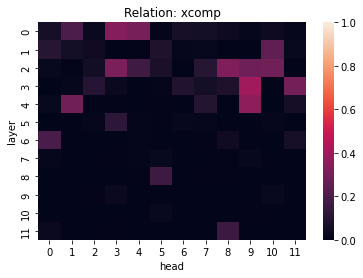

(3, 9) 0.40030951766830025


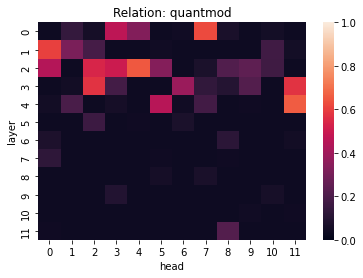

(4, 11) 0.6583011583011583


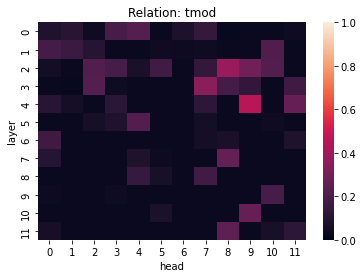

(4, 9) 0.45054945054945056


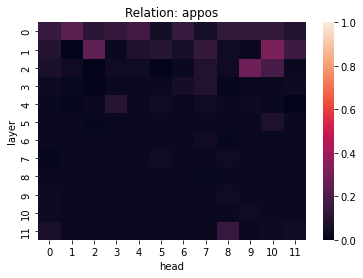

(1, 10) 0.3119614429677231


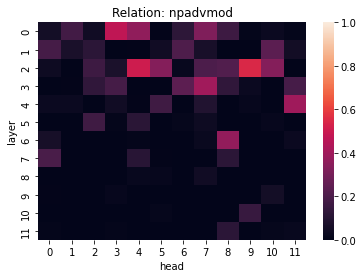

(2, 9) 0.5449940405244339


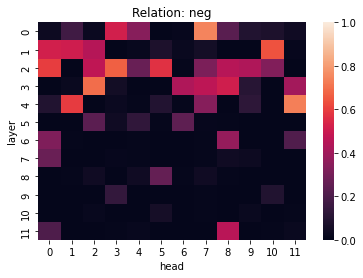

(0, 7) 0.7440644739708124


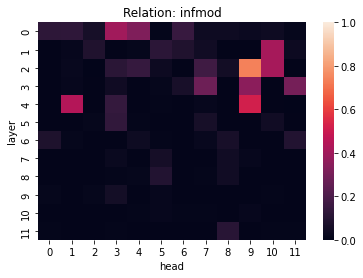

(2, 9) 0.737625754527163


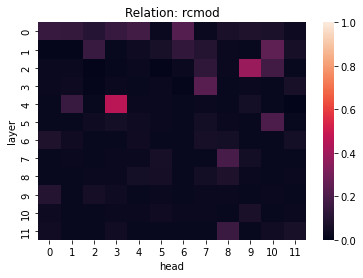

(4, 3) 0.45922241131038094


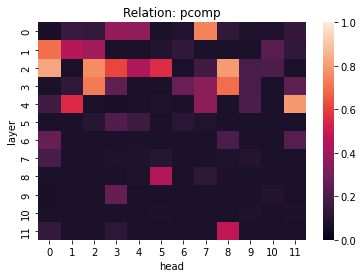

(2, 0) 0.8212246505217563


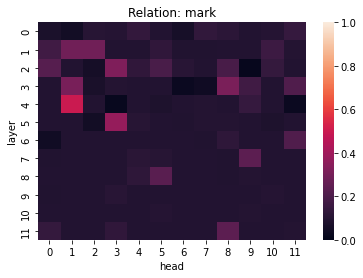

(4, 1) 0.49855324074074076


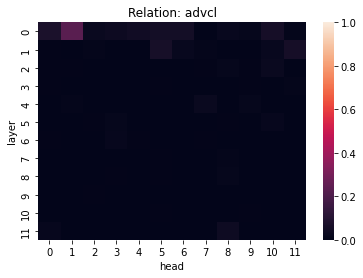

(0, 1) 0.23429991714995857


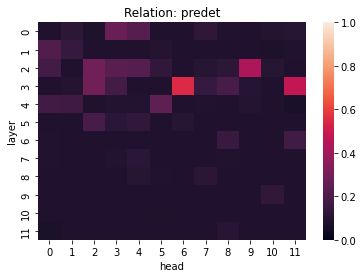

(3, 6) 0.5469613259668509


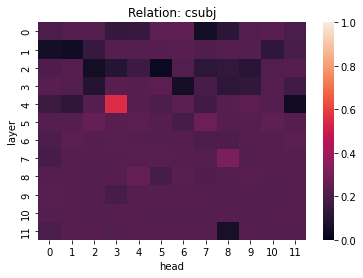

(4, 3) 0.5582010582010583


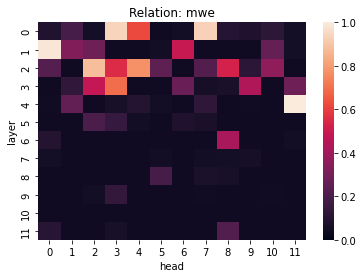

(4, 11) 0.998472116119175


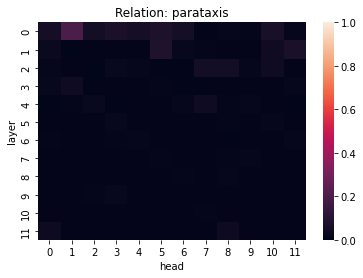

(0, 1) 0.19654714475431606


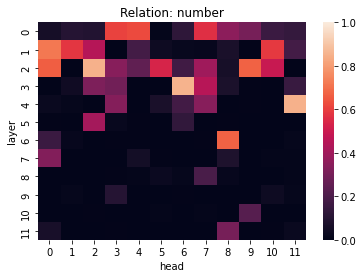

(3, 6) 0.85212722015696


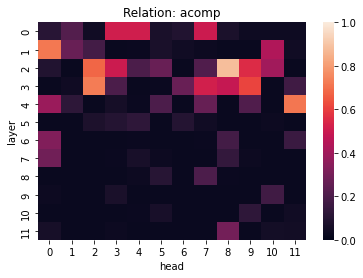

(2, 8) 0.8819133034379671


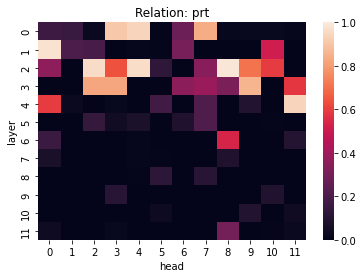

(2, 8) 0.9882039573820396


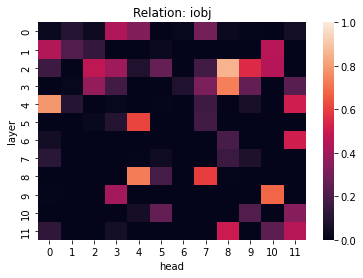

(2, 8) 0.8537906137184116


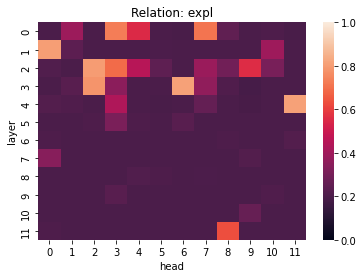

(3, 6) 0.8105263157894737


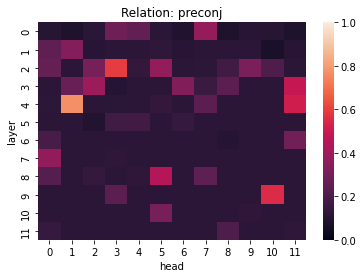

(4, 1) 0.7681159420289855


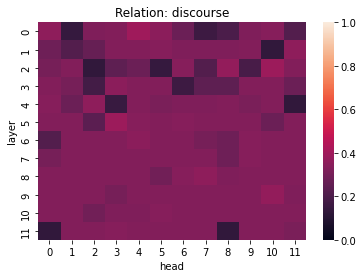

(0, 4) 0.39622641509433965


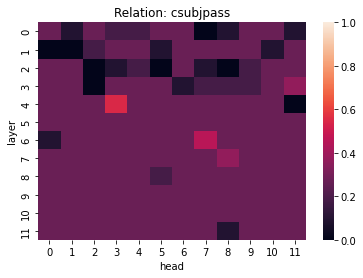

(4, 3) 0.5454545454545454


In [82]:
top_heads = {}
for dep_name, scores in mean_scores.items():
    sns.heatmap(scores, vmin=0, vmax=1)
    plt.title('Relation: ' + dep_name)
    plt.xlabel('head')
    plt.ylabel('layer')
    plt.show()
    max_index = np.argmax(scores)
    unraveled_idx = np.unravel_index(max_index, scores.shape)
    if unraveled_idx in top_heads:
        top_heads[unraveled_idx] += 1
    else:
        top_heads[unraveled_idx] = 1
    print(unraveled_idx, scores[unraveled_idx])


In [185]:
top_heads_expand = {}
for dep_name, scores in mean_scores.items():
    for idx in np.argwhere(scores>0.6):
        idx = tuple(idx)
        if idx in top_heads_expand:
            top_heads_expand[idx] += 1
        else:
            top_heads_expand[idx] = 1


In [186]:
len(top_heads_expand)

30

## Lesioning GPT2

In [254]:
''' data available here: https://osf.io/sr3ag/
'''
data_folder = './SLT_Public/Data/cleaned/'
response_data = []
fis = os.listdir(data_folder)
for fi_name in fis:
    if '.txt' in fi_name:
        with open(data_folder+fi_name) as fi:
            subj_id = fi_name.strip('.txt')
            lines = fi.readlines()
            text = ' '.join(lines)
            response_data.append({'subj': subj_id,
                         'text': text})

study_info = pd.read_csv('./SLT_Public/Data/Study1Info.csv')
for subj_data in response_data:
    subj_id = subj_data['subj']
    if study_info[study_info.SubjectID==subj_id].empty:
        subj_data['subj_type'] = 'control'
        subj_data['subj_type_collapse'] = 'control'
    else:
        subj_data['subj_type'] = study_info[study_info.SubjectID==subj_id]['Subtype'].iloc[0]
        subj_data['subj_type_collapse'] = 'aphasia'

In [249]:
def collapse_PPA(item):
    if 'PPA' in item:
        return 'aphasia'
    else:
        return item

df['subj_type_collapse'] = df.subj_type.apply(collapse_PPA)

In [128]:
def get_surprisals(text, remove_heads=None):
    head_mask=torch.ones((12, 12))
    if remove_heads:
        for head in remove_heads:
            head_mask[head] = 0
    
    inputs = tokenizer(text, return_tensors="pt")
    indexed_tokens = inputs['input_ids']

    with torch.no_grad():
        logprobs = model(**inputs, head_mask=head_mask).logits.log_softmax(dim=2).squeeze()

    logprobs = (None,) + logprobs.unbind()
    surprisals = []
    for j, token_idx in enumerate(indexed_tokens.squeeze()):
        if logprobs[j] == None: 
            surprisal = 0
        else:
            # find the log prob of the actual token in the vocab at the ith sentence position
            surprisal = -logprobs[j][token_idx].item() / torch.log(torch.tensor(2))
        surprisals.append(float(surprisal))

    return surprisals

In [ ]:
sequence_surprisals = []
for subj_data in response_data:
    surprisals = get_surprisals(subj_data['text'])
    score = np.mean(surprisals[1:])
    sequence_surprisals.append({'subj':subj_data['subj'], 'subj_type':subj_data['subj_type_collapse'], 'score':score, 'lesion': 'no'})
    
    lesion_surprisals = get_surprisals(subj_data['text'], remove_heads=list(top_heads_expand.keys()))
    lesion_score = np.mean(lesion_surprisals[1:])
    sequence_surprisals.append({'subj':subj_data['subj'], 'subj_type':subj_data['subj_type_collapse'], 'score':lesion_score, 'lesion':'yes'})

df = pd.DataFrame(sequence_surprisals)

### Classification before lesions

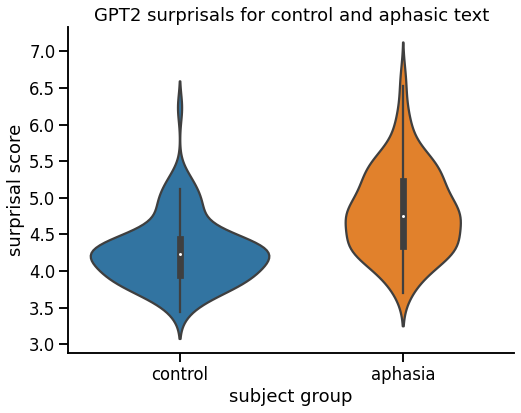

In [345]:
fig, ax = plt.subplots(figsize=(8, 6))
non_lesion = df[df.lesion=='no']
sns.violinplot(x="subj_type", y="score", data=non_lesion, ax=ax, order=['control', 'aphasia'])#, order=['control', 'nfvPPA', 'lvPPA', 'svPPA'], data=df)

plt.title("GPT2 surprisals for control and aphasic text")
plt.xlabel("subject group")
plt.ylabel("surprisal score")
sns.despine(right = True)
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


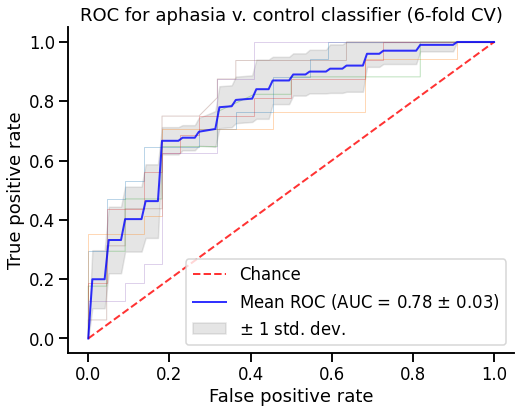

In [347]:
sns.set_context("talk") 

selection = df[df.lesion=='no']
X = np.array(selection.score).reshape(-1, 1)
y = np.array(selection.subj_type)


# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel="linear", probability=True, random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
accuracies = []
fig, ax = plt.subplots(figsize=(8, 6))
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    y_pred = classifier.predict(X[test])
    y_true = y[test]
    accuracies.append(accuracy_score(y_true, y_pred))
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        label="",
        #name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC for aphasia v. control classifier (6-fold CV)",
    xlabel='False positive rate',
    ylabel='True positive rate'
)
ax.legend(loc="lower right")
sns.despine(right = True)
plt.show()

### Classification after syntax lesion

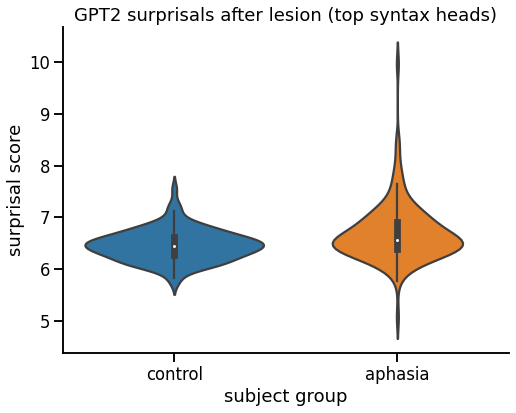

In [348]:
fig, ax = plt.subplots(figsize=(8, 6))
non_lesion = df[df.lesion=='yes']
sns.violinplot(x="subj_type", y="score", data=non_lesion, ax=ax, order=['control', 'aphasia'])#, order=['control', 'nfvPPA', 'lvPPA', 'svPPA'], data=df)

plt.title("GPT2 surprisals after lesion (top syntax heads)")
plt.xlabel("subject group")
plt.ylabel("surprisal score")
sns.despine(right = True)
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


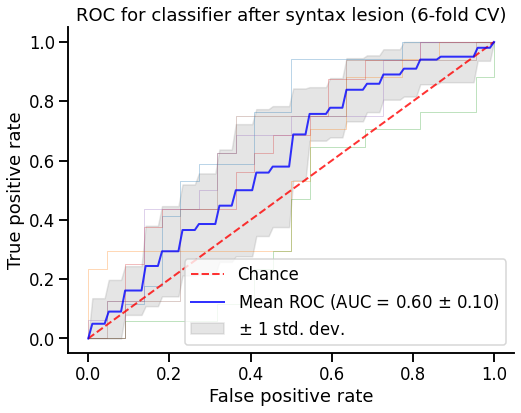

In [376]:
sns.set_context("talk") 

selection = df[df.lesion=='yes']
X = np.array(selection.score).reshape(-1, 1)
y = np.array(selection.subj_type)


# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel="linear", probability=True, random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
accuracies = []
fig, ax = plt.subplots(figsize=(8, 6))
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    y_pred = classifier.predict(X[test])
    y_true = y[test]
    accuracies.append(accuracy_score(y_true, y_pred))
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        label="",
        #name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC for classifier after syntax lesion (6-fold CV)",
    xlabel='False positive rate',
    ylabel='True positive rate'
)
ax.legend(loc="lower right")
sns.despine(right = True)
plt.show()

### Classification after random lesion

In [ ]:
def random_head(exclude=None):
    choice = tuple(np.random.choice(12, 2))
    if exclude:
        while choice in exclude:
            choice = tuple(np.random.choice(12, 2))
    return choice

In [ ]:
random_heads = [random_head(exclude=top_heads_expand.keys()) for i in range(len(top_heads_expand))]

sequence_surprisals = []
for subj_data in response_data:
    surprisals = get_surprisals(subj_data['text'])
    #score = get_surprisals(subj_data['text']) #reduction gets surprisals
    score = np.mean(surprisals[1:])
    sequence_surprisals.append({'subj':subj_data['subj'], 'subj_type':subj_data['subj_type_collapse'], 'score':score, 'lesion': 'no'})
    #subj_data['score'] = np.mean(score[1:])
    
    lesion_surprisals = get_surprisals(subj_data['text'], remove_heads=random_heads)
    lesion_score = np.mean(lesion_surprisals[1:])
    #score = get_surprisals(subj_data['text']) #reduction gets surprisals
    sequence_surprisals.append({'subj':subj_data['subj'], 'subj_type':subj_data['subj_type_collapse'], 'score':lesion_score, 'lesion':'yes'})
    #subj_data['score'] = np.mean(score[1:]

df = pd.DataFrame(sequence_surprisals)

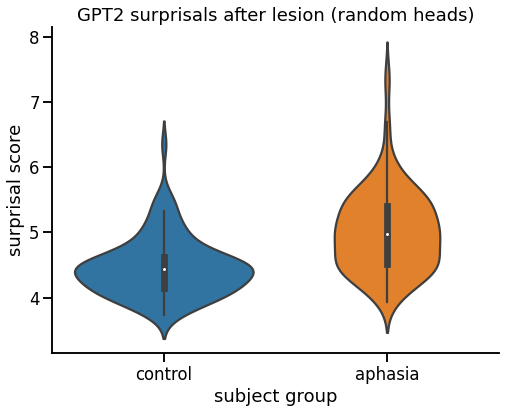

In [378]:
fig, ax = plt.subplots(figsize=(8, 6))
lesion = df[df.lesion=='yes']
sns.violinplot(x="subj_type", y="score", data=lesion, ax=ax, order=['control', 'aphasia'])#, order=['control', 'nfvPPA', 'lvPPA', 'svPPA'], data=df)
#sns.violinplot(x="lesion", y="score", hue="subj_type", data=df, ax=ax, split=True, order=['no', 'yes'])
#ax.set(ylim=(3, 11))

plt.title("GPT2 surprisals after lesion (random heads)")
plt.xlabel("subject group")
plt.ylabel("surprisal score")
sns.despine(right = True)
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


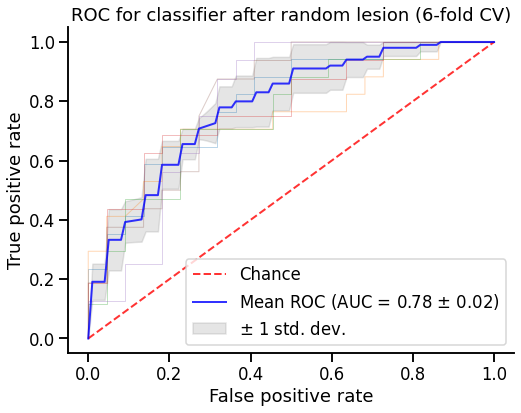

In [379]:
sns.set_context("talk") 

selection = df[df.lesion=='yes']
X = np.array(selection.score).reshape(-1, 1)
y = np.array(selection.subj_type)


# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel="linear", probability=True, random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
accuracies = []
fig, ax = plt.subplots(figsize=(8, 6))
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    y_pred = classifier.predict(X[test])
    y_true = y[test]
    accuracies.append(accuracy_score(y_true, y_pred))
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        label="",
        #name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC for classifier after random lesion (6-fold CV)",
    xlabel='False positive rate',
    ylabel='True positive rate'
)
ax.legend(loc="lower right")
sns.despine(right = True)
plt.show()